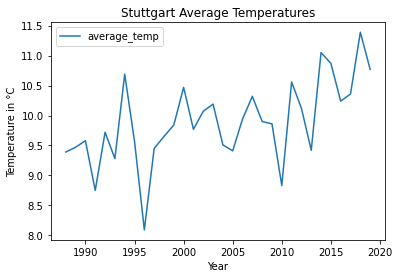

       average_temp
count     32.000000
mean       9.891562
std        0.695970
min        8.090000
25%        9.465000
50%        9.850000
75%       10.330000
max       11.390000


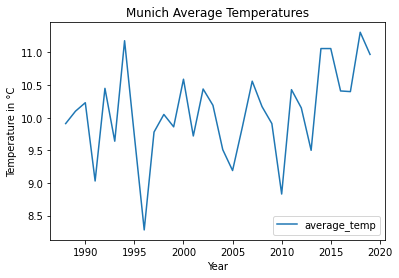

       average_temp
count     32.000000
mean      10.077813
std        0.687003
min        8.280000
25%        9.720000
50%       10.125000
75%       10.442500
max       11.310000


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import sklearn.datasets
import numpy as np
#import sys
#from scipy.stats import norm
#import scipy.stats as stats
#import pylab as 

# meteoblue erlaubt einen Datendownload nur von den letzten zwei Wochen ohne history+ Abo, daher als Quelle nicht geeignet (116€ pro Location)
# DWD https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/annual/kl/historical/
# DWD Klimadaten Stuttgart:
#   Messstation Stuttgart Echterdingen Messstationsid 04931
# DWD Klimadaten München:
#   Messstation München-Stadt Messstationsid 03379

#Cities: Stuttgart, München
#Steps to solve:
#1.    Perform a EDA and plot the data. What can you see now?

# import data
stuttgart = pd.read_csv('climachange_stuttgart-echterdingen.csv', sep = ';', decimal= ".", parse_dates=['MESS_DATUM_ENDE'])
munich = pd.read_csv('climachange_münchen-stadt.csv', sep = ';', decimal= ".", parse_dates=['MESS_DATUM_ENDE'])

# extract average temperature and years
stuttgart_temp = pd.DataFrame({'year': stuttgart['MESS_DATUM_ENDE'].values,'average_temp': stuttgart['JA_TT'].values})
munich_temp = pd.DataFrame({'year': munich['MESS_DATUM_ENDE'].values,'average_temp': munich['JA_TT'].values})

# convert date to year
stuttgart_temp['year'] = stuttgart_temp['year'].dt.year
munich_temp['year'] = munich_temp['year'].dt.year

# remove all data before 1988
stuttgart_older_years = stuttgart_temp[stuttgart_temp['year'] < 1988].index
stuttgart_temp.drop(stuttgart_older_years, inplace=True)

munich_older_years = munich_temp[munich_temp['year'] < 1988].index
munich_temp.drop(munich_older_years, inplace=True)

# set year as index
stuttgart_temp.set_index('year', inplace = True)
munich_temp.set_index('year', inplace = True)

# plot data stuttgart
stuttgart_ax = stuttgart_temp.plot(title = 'Stuttgart Average Temperatures')
stuttgart_ax.set_ylabel("Temperature in °C")
stuttgart_ax.set_xlabel("Year")
plt.show()
print(stuttgart_temp.describe())

# plot data munich
munich_ax = munich_temp.plot(title = 'Munich Average Temperatures')
munich_ax.set_ylabel("Temperature in °C")
munich_ax.set_xlabel("Year")
plt.show()
print(munich_temp.describe())


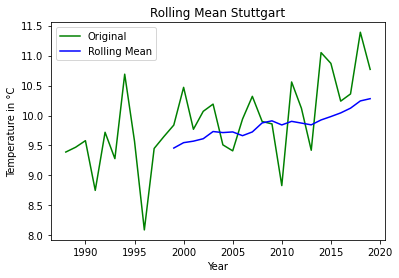

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-3.879054586545904, 0.0021945169729150273, 0, 31, {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}, nan)
df_output: 
 Test Statistic                 -3.879055
p-value                         0.002195
#Lags Used                      0.000000
Number of Observations Used    31.000000
dtype: float64
Test Statistic                 -3.879055
p-value                         0.002195
#Lags Used                      0.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64




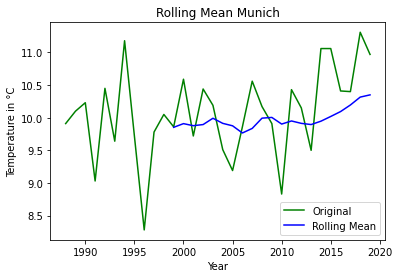

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-4.5701020741416265, 0.00014659085435750506, 0, 31, {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}, 42.31785402878093)
df_output: 
 Test Statistic                 -4.570102
p-value                         0.000147
#Lags Used                      0.000000
Number of Observations Used    31.000000
dtype: float64
Test Statistic                 -4.570102
p-value                         0.000147
#Lags Used                      0.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


Conclusion:
p < 0.05 at both locations -> data series are stationary -> no random walk


In [29]:
#2. Is Temperature a Random Walk (with Drift)?
#       An ARIMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.
#       Plot the data and test whether it follows a random walk (with drift).

#Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def stationarity_check(ts, location):
    
    # Determing rolling statistics
    roll_mean = ts.rolling(center=False,window=12).mean()
    # Plot rolling statistics:
    plt.plot(ts, color='green',label='Original')
    plt.plot(roll_mean, color='blue', label='Rolling Mean')
    plt.ylabel("Temperature in °C")
    plt.xlabel("Year")
    plt.legend(loc='best')
    plt.title('Rolling Mean ' + location)
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller test:
    print('Augmented Dickey-Fuller test:')
    df_test = adfuller(ts)
    print("type of df_test: ",type(df_test))
    print("df_test: ",df_test)
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print("df_output: \n",df_output)
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

# perform stationary check with ADF in stuttgart
stationarity_check(stuttgart_temp['average_temp'], 'Stuttgart')
# perform stationary check with ADF in munich
print('\n')
stationarity_check(munich_temp['average_temp'], 'Munich')

#print test conclusion
print('\n\nConclusion:')
print('p < 0.05 at both locations -> data series are stationary -> no random walk')

Stuttgart



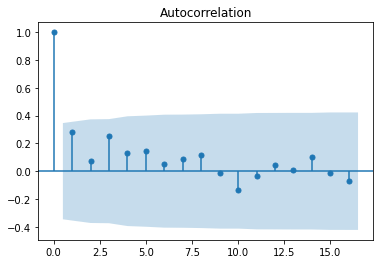

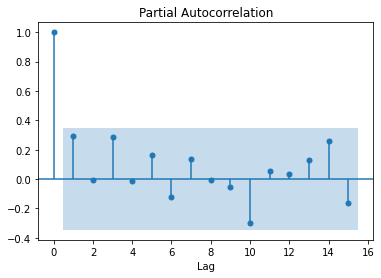


Munich



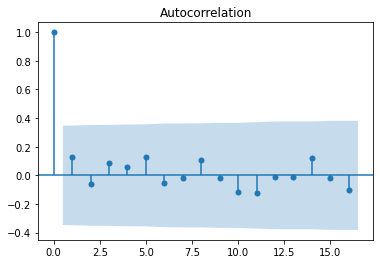

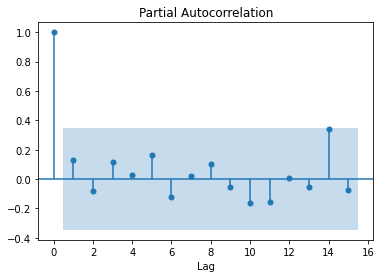

In [30]:
#3. Look at Autocorrelations
#       If the temperature series is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# the temperature series are no random walk and stationary (see 2.) -> no differencing is needed

# calculate ACF and PACF for Stuttgart
print('Stuttgart\n')
plot_acf(stuttgart_temp)
plot_pacf(stuttgart_temp, lags = 15)
plt.xlabel("Lag")
plt.show()
# calculate ACF and PACF for Munich
print('\nMunich\n')
plot_acf(munich_temp)
plot_pacf(munich_temp, lags = 15)
plt.xlabel("Lag")
plt.show()


In [31]:
#4. Which ARMA Model is Best?
#   Recall from theory that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more             parameters #to discourage overfitting. Lower AIC scores are better.
#   Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.
from statsmodels.tsa.arima_model import ARMA

# compare AR(1), AR(2), and ARMA(1,1) for Munich with the AIC criterion
print('Munich\n')
# ARMA(1,1)
munich_mod1 = ARMA(munich_temp['average_temp'].values,order=(1,1))
munich_results1 = munich_mod1.fit()
print('ARMA(1,1) - AIC:{}'.format(munich_results1.aic))
# AR(1)
munich_mod2 = ARMA(munich_temp['average_temp'].values, order=(1, 0))
munich_results2 = munich_mod2.fit()
print('AR(1) - AIC:{}'.format(munich_results2.aic))
# AR(2)
munich_mod3 = ARMA(munich_temp['average_temp'].values, order=(2, 0))
munich_results3 = munich_mod3.fit()
print('AR(2) - AIC:{}'.format(munich_results3.aic))

# compare AR(1), AR(2), and ARMA(1,1) for Munich with the AIC criterion
print('\nStuttgart\n')
# ARMA(1,1)
# TODO das Modell ARMA(1,1) kann ich bei den Stuttgart Daten nicht anwenden, es wird ein Fehler geworfen
stuttgart_mod1 = ARMA(stuttgart_temp['average_temp'].values,order=(1,1))
stuttgart_results1 = stuttgart_mod1.fit()
print('ARMA(1,1) - AIC:{}'.format(stuttgart_results1.aic))
# AR(1)
stuttgart_mod2 = ARMA(stuttgart_temp['average_temp'].values, order=(1, 0))
stuttgart_results2 = stuttgart_mod2.fit()
print('AR(1) - AIC:{}'.format(stuttgart_results2.aic))
# AR(2)
stuttgart_mod3 = ARMA(stuttgart_temp['average_temp'].values, order=(2, 0))
stuttgart_results3 = stuttgart_mod3.fit()
print('AR(2) - AIC:{}'.format(stuttgart_results3.aic))

#print conclusion
print('\n\nConclusion:')
print('AR(1) is the best fit model')


Munich

ARMA(1,1) - AIC:72.62278409719804
AR(1) - AIC:71.23503432771784
AR(2) - AIC:73.07918203494594

Stuttgart



LinAlgError: SVD did not converge

Munich



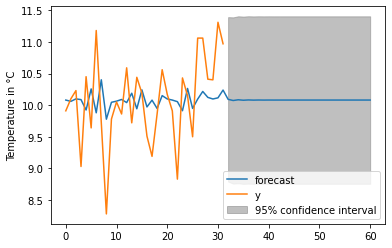


Stuttgart



MissingDataError: exog contains inf or nans

In [23]:
#5. Don't Throw Out That Winter Coat Yet?
#       Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.
#       Earlier, you determined that the temperature data follows a random walk and you looked at first differencing the data. In this exercise, you will use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

# Munich calculate 30 year prediction
print('Munich\n')
model1 = ARMA(munich_temp['average_temp'].values, order=(1,1))
results_MA1 = model1.fit()
# TODO mit den Parametern start=1988, end=2050 und dynamic=True funktioniert nichts
results_MA1.plot_predict(start=0, end=60, dynamic=False)
plt.ylabel('Temperature in °C')
plt.show()
# Stuttgart calculate 30 year prediction
print('\nStuttgart\n')
# TODO das Modell ARMA(1,1) kann ich bei den Stuttgart Daten nicht anwenden, es wird ein Fehler geworfen
model2 = ARMA(stuttgart_temp['average_temp'].values, order=(1,1))
results_MA2 = model2.fit()
# TODO mit den Parametern start=1988, end=2050 und dynamic=True funktioniert nichts
results_MA2.plot_predict(start=0, end=60, dynamic=False)
plt.ylabel('Temperature in °C')
plt.show()


In [ ]:
#Hints:
#   a. In your task folder should be provided an original file for analysis and processed file as well;
#   b. In your task folder should be provided a workable solution file:
#       i. A line of codes should be commented
#       ii. Graphics should have clear titles, axis names and description
#       iii. Test data and its purposes should be clearly specified
#   c. In your task folder should be provided a short documentation of your research with target and conclusions. The documentation should be provided in .pptx form